Problem statement.

Build a recommender system by using cosine simillarties score.


In [200]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import os
import requests
import seaborn as sns
from sklearn.metrics import pairwise_distances

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors # unsupervised ML algo


from PIL import Image

warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [175]:
book_data = pd.read_csv("books.csv",encoding='latin-1')
book_data.head()

,User.ID,Book.Title,Book.Rating
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [176]:
books_ = pd.read_csv("books_data.csv")
books_.book_title.unique()

array(['Classical Mythology', 'Clara Callan', 'Decision in Normandy', ...,
       'Why stop?: A guide to Texas historical roadside markers',
       "The Are You Being Served? Stories: 'Camping In' and Other Fiascoes",
       'Dallas Street Map Guide and Directory, 2000 Edition'],
      dtype=object)

In [177]:
books_[books_.book_title == "Clara Callan"].iloc[0].img_l

'http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg'

In [178]:
book_data['Book.Title'] = book_data['Book.Title'].apply(lambda x: x.replace("&amp;", "") if "&amp;" in x else x)

<AxesSubplot:xlabel='Book.Rating', ylabel='count'>

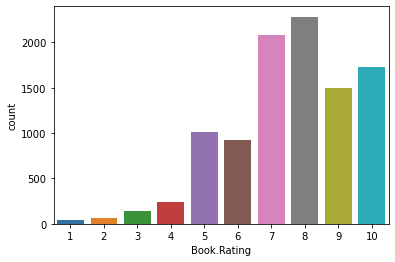

In [183]:
sns.countplot(x='Book.Rating', data=book_data)

In [ ]:
title=[]
images=[]
for i in book_data["Book.Title"].values:
   # print(i)
    if i in list(books_["book_title"].unique()):
        #print(i + " present")
        title.append(i)
        images.append(books_[books_.book_title == i].iloc[0].img_l)
    else:
        title.append(i)
        images.append("")
    
            

In [184]:
book_data["URL"] = images
book_data.tail()

,User.ID,Book.Title,Book.Rating,URL
9995,162121,American Fried: Adventures of a Happy Eater.,7,http://images.amazon.com/images/P/0140040188.0...
9996,162121,Cannibal In Manhattan,9,http://images.amazon.com/images/P/0330305336.0...
9997,162121,How to Flirt: A Practical Guide,7,http://images.amazon.com/images/P/0843133805.0...
9998,162121,Twilight,8,http://images.amazon.com/images/P/0671644076.0...
9999,162129,Kids Say the Darndest Things,6,http://images.amazon.com/images/P/0553110438.0...


Item based collaborative filtering

In [196]:
# Renaming columns
book_data = book_data.rename({'User.ID':'user_id', 'Book.Title':'book_title', 'Book.Rating':'book_rating'}, axis = 1)
book_data.head()

,user_id,book_title,book_rating,URL
0,276726,Classical Mythology,5,http://images.amazon.com/images/P/0195153448.0...
1,276729,Clara Callan,3,http://images.amazon.com/images/P/0002005018.0...
2,276729,Decision in Normandy,6,http://images.amazon.com/images/P/0060973129.0...
3,276736,Flu: The Story of the Great Influenza Pandemic...,8,http://images.amazon.com/images/P/0374157065.0...
4,276737,The Mummies of Urumchi,6,http://images.amazon.com/images/P/0393045218.0...


In [197]:
books_df = book_data.pivot_table(index='user_id',
                                 columns='book_title',
                                 values='book_rating').reset_index(drop=True)
books_df.head()

book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:

books_df.index = book_data['user_id'].unique()

In [199]:
books_df.fillna(0, inplace=True)
books_df.head()

book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
276726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
#Calculating Cosine Similarity between Users
user_similarity = 1 - pairwise_distances(books_df.values,metric='cosine')
#user_similarity

In [203]:
user_sim_df = pd.DataFrame(user_similarity)

user_sim_df.index = book_data.user_id.unique()
user_sim_df.columns = book_data.user_id.unique()
user_sim_df.head()

,276726,276729,276736,276737,276744,276745,276747,276748,276751,276754,...,162085,162091,162092,162095,162103,162107,162109,162113,162121,162129
276726,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276736,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276737,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276744,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
# Filling diagonal values with 0
np.fill_diagonal(user_similarity, 0)
user_sim_df.iloc[0:5, 0:5]

,276726,276729,276736,276737,276744
276726,0.0,0.0,0.0,0.0,0.0
276729,0.0,0.0,0.0,0.0,0.0
276736,0.0,0.0,0.0,0.0,0.0
276737,0.0,0.0,0.0,0.0,0.0
276744,0.0,0.0,0.0,0.0,0.0


In [268]:
#Most Similar Users
user_sim_df.idxmax(axis=1)[0:10]

276726    276726
276729    276726
276736    276726
276737    276726
276744    276726
276745    276726
276747    276726
276748    161677
276751    276726
276754    276726
dtype: int64

In [254]:
similar_ = book_data[(book_data['user_id']==276729) | (book_data['user_id']==276726)]
similar_

,user_id,book_title,book_rating,URL
0,276726,Classical Mythology,5,http://images.amazon.com/images/P/0195153448.0...
1,276729,Clara Callan,3,http://images.amazon.com/images/P/0002005018.0...
2,276729,Decision in Normandy,6,http://images.amazon.com/images/P/0060973129.0...


In [275]:
def book_recommender(user1, user2):
    similar_users = book_data[(book_data['user_id']==user1) | (book_data['user_id']==user2)]
    #print(similar_users)
    fig, axs = plt.subplots(1, similar_users.shape[0],figsize=(15,5))
    fig.suptitle('Books recommendation based on user similarity', size = 22)
          
    
    for i in range(len(similar_users['book_title'].tolist())):
    
        
        url = similar_users.iloc[i].URL
        #print(url)
        if url !="":
            #print(url)
            im = Image.open(requests.get(url, stream=True).raw)
            axs[i].imshow(im)
            axs[i].axis("off")
            axs[i].set_title('{0} \n Rating: {1}  \n User ID: {2}'.format(similar_users.iloc[i].book_title, similar_users.iloc[i].book_rating, similar_users.iloc[i].user_id),y=-0.21,color="red",fontsize=14)
        
            fig.show()
                
        else:
            axs[i].axis("off")
            """axs[i].set_title('{0} \n Rating: {1}'.format(similar_users.iloc[i].book_title, similar_users.iloc[i].book_rating,
                             y=-0.18,color="red",fontsize=10)"""
            fig.show()
                    

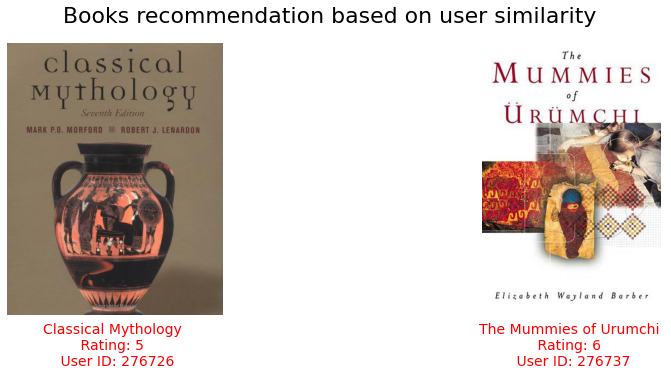

In [276]:
book_recommender(276737, 276726)

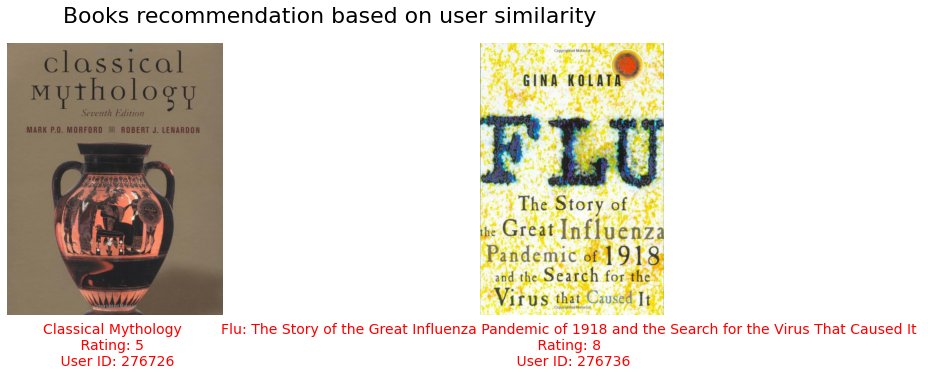

In [277]:
book_recommender(276736, 276726)

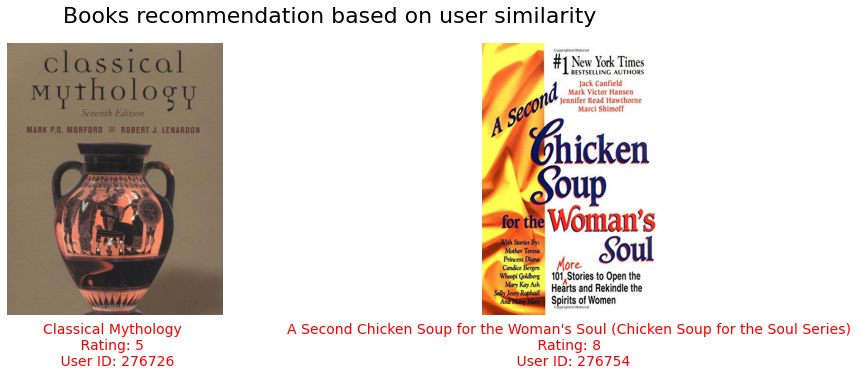

In [282]:
book_recommender(276754,276726)

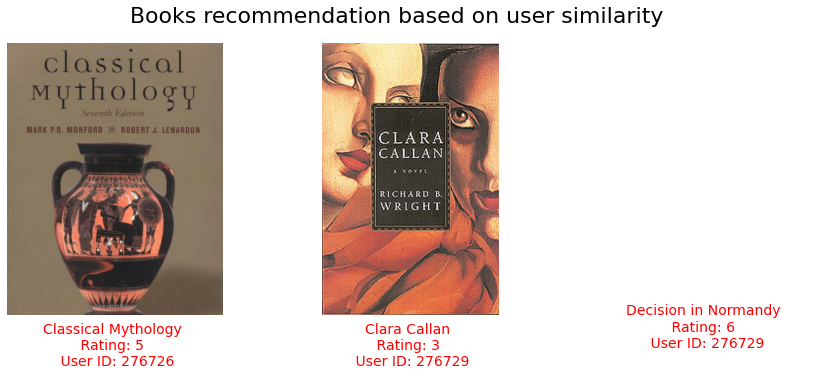

In [278]:
book_recommender(276729, 276726)

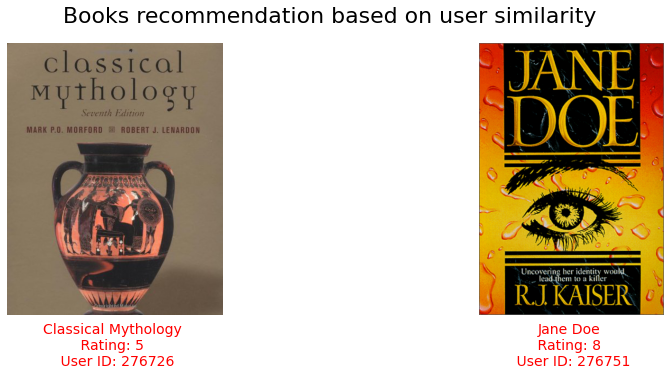

In [279]:
book_recommender(276751, 276726)

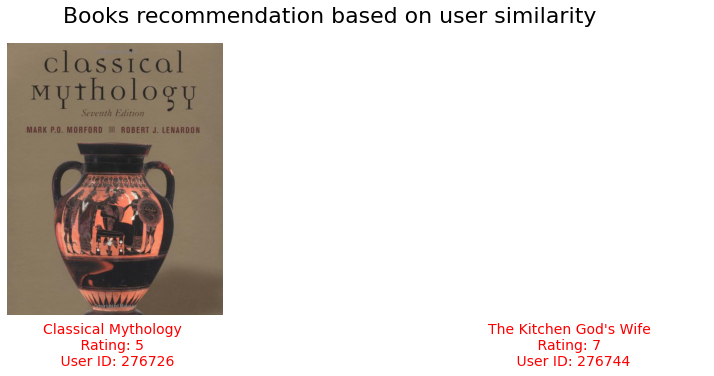

In [280]:
book_recommender(276744, 276726)

In [209]:
user1=book_data[book_data['user_id']==276726]

In [210]:
user2=book_data[book_data['user_id']==276729]

In [211]:
pd.merge(user1,user2,on='book_title',how='outer')

,user_id_x,book_title,book_rating_x,URL_x,user_id_y,book_rating_y,URL_y
0,276726.0,Classical Mythology,5.0,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN
1,NaN,Clara Callan,NaN,NaN,276729.0,3.0,http://images.amazon.com/images/P/0002005018.0...
2,NaN,Decision in Normandy,NaN,NaN,276729.0,6.0,http://images.amazon.com/images/P/0060973129.0...
